In [2]:
import tensorflow as tf
tfe = tf.contrib.eager

tf.enable_eager_execution()
tf.__version__

'1.10.0'

## 变量
TensorFlow中的张量是不可变的无状态对象。 然而，机器学习模型需要具有变化状态：随着模型训练，计算预测的相同代码应该随着时间的推移而表现不同（希望具有较低的损失！）。 要表示需要在计算过程中进行更改的状态，您可以选择依赖Python是一种有状态编程语言的事实：

In [3]:
x = tf.zeros([10,10])
x += 2
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


但是，TensorFlow内置了有状态操作，这些操作的效果通常比低级Python表示更好。 例如，为了表示模型中的权重，使用TensorFlow变量通常是方便有效的。

变量是一个存储值的对象，当在TensorFlow计算中使用时，它将隐式地从该存储值中读取。 有操作（tf.assign_sub，tf.scatter_update等）操作存储在TensorFlow变量中的值。

In [5]:
v = tfe.Variable(1.0)
assert v.numpy() == 1.0

v.assign(3.0)
assert v.numpy() == 3.0

v.assign(tf.square(v))
assert v.numpy() == 9.0

## 示例：拟合线性模型

现在让我们把我们迄今为止的几个概念--- Tensor，GradientTape，Variable ---构建并训练一个简单的模型。 这通常涉及几个步骤：

- 定义模型。
- 定义损失函数。
- 获取训练数据。
- 运行训练数据并使用“优化器”调整变量以适合数据。

在本教程中，我们将介绍简单线性模型的一个简单示例：f（x）= x * W + b，它有两个变量 - W和b。 此外，我们将合成数据，使训练有素的模型具有W = 3.0和b = 2.0。

### Define the model

In [9]:
class Model():
    def __init__(self):
        self.W = tfe.Variable(5.0)
        self.b = tfe.Variable(0.0)
    def __call__(self,x):
        return self.W*x + self.b
    
model = Model()
print(model(3.0).numpy())
assert model(3.0).numpy() == 15.0

### Define a loss function

In [10]:
def loss(predicted_y,desired_y):
    return tf.reduce_mean(tf.square(predicted_y-desired_y))

### Obtain training data
让我们用一些噪音合成训练数据。

In [11]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs = tf.random_normal(shape=[NUM_EXAMPLES])
noise = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs*TRUE_W +  TRUE_b + noise

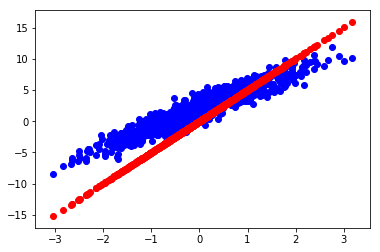

Current loss; 
8.720176


In [13]:
import matplotlib.pyplot as plt

plt.scatter(inputs,outputs,c='b')
plt.scatter(inputs,model(inputs),c='r')
plt.show()

print('Current loss; ')
print(loss(model(inputs),outputs).numpy())

## 定义训练循环
我们现在拥有我们的网络和培训数据。 让我们训练它，即使用训练数据来更新模型的变量（W和b），以便使用梯度下降来减少损失。 在tf.train.Optimizer实现中捕获了许多梯度下降方案的变体。 我们强烈建议使用这些实现，但本着从第一原则构建的精神，在这个特定的例子中，我们将自己实现基本的数学。

In [18]:
def train(model,inputs,outputs,learning_rate=0.1):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
    dW,db = t.gradient(current_loss,[model.W,model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

Epoch  0: W=5.00 b=0.00, loss=8.72018
Epoch  1: W=4.61 b=0.39, loss=5.98487
Epoch  2: W=4.30 b=0.71, loss=4.22059
Epoch  3: W=4.05 b=0.96, loss=3.08263
Epoch  4: W=3.85 b=1.16, loss=2.34864
Epoch  5: W=3.69 b=1.33, loss=1.87521
Epoch  6: W=3.56 b=1.46, loss=1.56985
Epoch  7: W=3.46 b=1.56, loss=1.37289
Epoch  8: W=3.37 b=1.65, loss=1.24585
Epoch  9: W=3.31 b=1.71, loss=1.16391


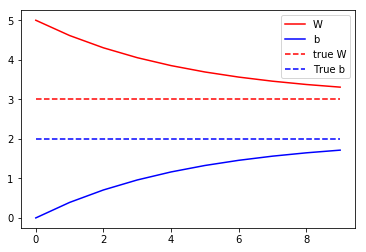

In [19]:
model = Model()
# Collect the history of W-values and b-values to plot later
Ws,bs = [],[]
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs),outputs)
    train(model,inputs,outputs,learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

plt.plot(epochs,Ws,'r',epochs,bs,'b')
plt.plot([TRUE_W]*len(epochs),'r--',
        [TRUE_b]*len(epochs),'b--')
plt.legend(['W','b','true W','True b'])
plt.show()